# Calibration methods comparison: simulated predictions on 2-simplex

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
import random
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.isotonic import IsotonicRegression
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input
from tensorflow.keras.optimizers import Adam, SGD

import torch

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport flows.nice
%aimport flows.normalizing_flows
%aimport flows.normalizing_flows_torch
%aimport calibrators
from utils.ops import onehot_encode, optim_temperature, detection_log_likelihood_ratios
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_plot, reliability_diagram, ECE_plot, plot_cal_regions_ternary
from flows.nice import AddCouplingLayer, MLP, ReIndex
from flows.normalizing_flows_torch import PlanarFlow, RadialFlow
from calibrators import PAVCalibrator, MLRCalibrator, NiceCalibrator, TempScalingCalibrator, RealNvpCalibrator, TorchFlowCalibrator

/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: P

In [4]:
# Select GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 

In [5]:
%matplotlib inline
np.random.seed(2)

### Generate fake target distribution and simulated predictions

In [6]:
n_samples = 1500

target = np.array(random.choices(range(3), k=n_samples))
one_hot = onehot_encode(target)

# Shift
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.3

# Twist
twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), target-1] = 0.7 + np.random.randn(n_samples)*0.1

snt_logits = np.float32(0.8 * (one_hot + twisting + np.random.randn(n_samples, 3)*0.3) + offset)

# 0-center logits
snt_logits -= np.mean(snt_logits, axis=1, keepdims=True)

snt_probs = softmax(snt_logits, axis=1)

nll = neg_log_likelihood(snt_probs, target)
ECE = expected_calibration_error(snt_probs, target)

print("Negative log-likelihood of the classifier predictions: {:.5f}".format(nll))
print("Expected Calibration Error of the classifier predictions: {:.5f}".format(ECE))

Negative log-likelihood of the classifier predictions: 0.84270
Expected Calibration Error of the classifier predictions: 0.22769


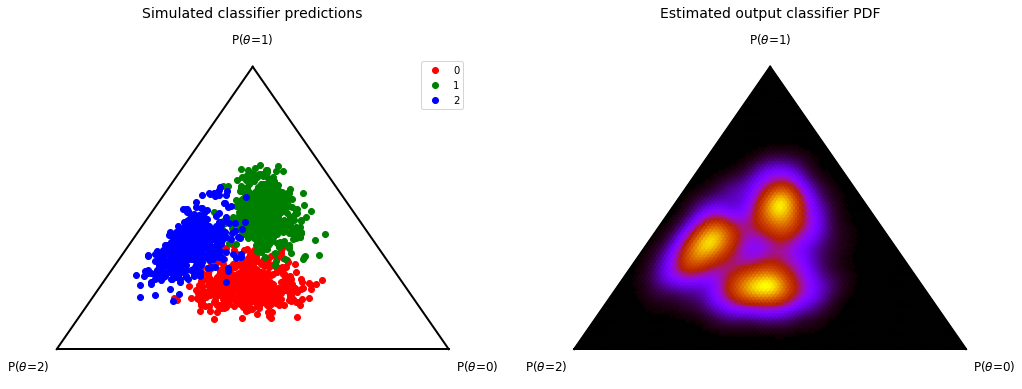

In [7]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
ax_arr[0] = plot_prob_simplex(snt_probs, target=target, ax=ax_arr[0], title='Simulated classifier predictions', fontsize=12);
ax_arr[1] = plot_pdf_simplex(snt_probs, scale=100, ax=ax_arr[1], title='Estimated output classifier PDF', fontsize=12);
plt.show()

## Fit calibrators

Fitted PlanarFlow in 104.211s
Fitted RadialFlow in 88.275s
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fitted NICE in 74.030s
Fitted RealNVP in 77.595s


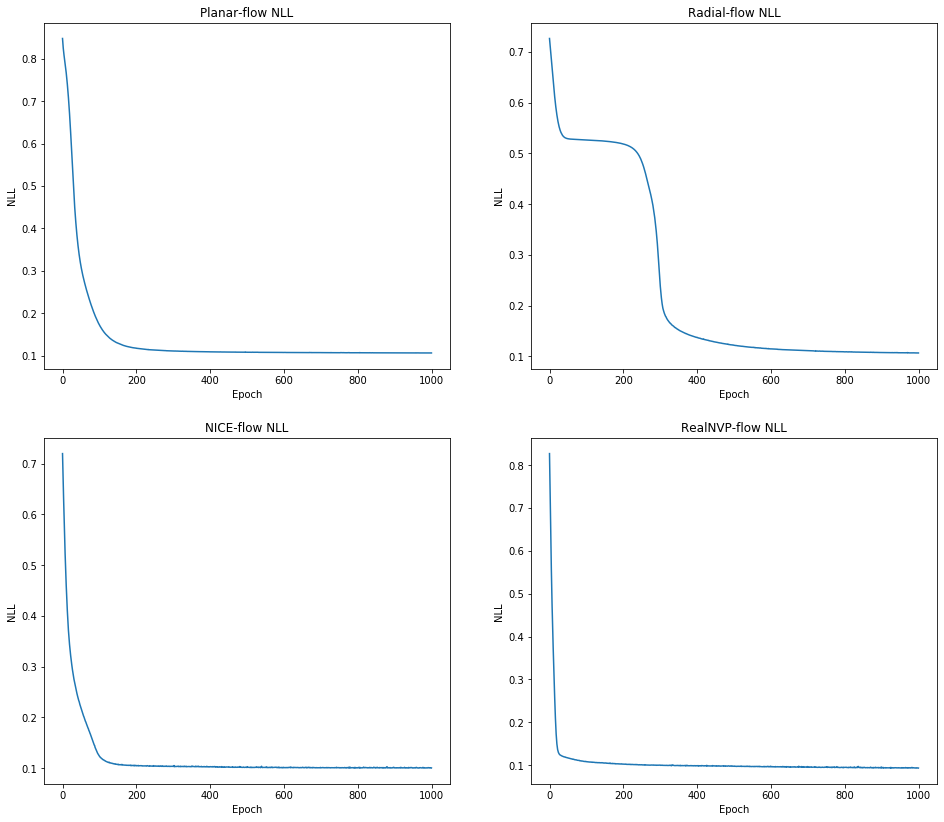

In [8]:
## Temp-Scaling
temp_cal = TempScalingCalibrator(snt_logits, target)
temp_probs = temp_cal.predict(snt_logits)

nll_temp = neg_log_likelihood(temp_probs, target)
ECE_temp = expected_calibration_error(temp_probs, target)


## Multiclass PAV
pav_cal = PAVCalibrator(snt_logits, target)
pav_probs = pav_cal.predict(snt_logits)

nll_pav = neg_log_likelihood(pav_probs, target)
ECE_pav = expected_calibration_error(pav_probs, target)


## MLR
mlr_cal = MLRCalibrator(snt_logits, target)
mlr_probs = mlr_cal.predict(snt_logits)

nll_mlr = neg_log_likelihood(mlr_probs, target)
ECE_mlr = expected_calibration_error(mlr_probs, target)


## Planar flow
t0 = time.time()
pln_cal = TorchFlowCalibrator(PlanarFlow, snt_logits, target, layers=5)
print('Fitted PlanarFlow in {:.3f}s'.format(time.time()-t0))
pln_probs = pln_cal.predict(snt_logits)

nll_pln = neg_log_likelihood(pln_probs, target)
ECE_pln = expected_calibration_error(pln_probs, target)


## Radial flow
t0 = time.time()
rdl_cal = TorchFlowCalibrator(RadialFlow, snt_logits, target, layers=5)
print('Fitted RadialFlow in {:.3f}s'.format(time.time()-t0))
rdl_probs = rdl_cal.predict(snt_logits)

nll_rdl = neg_log_likelihood(rdl_probs, target)
ECE_rdl = expected_calibration_error(rdl_probs, target)


## NICE flow
t0 = time.time()
nice_cal = NiceCalibrator(snt_logits, target, layers=4, hidden_size=[3, 3], version=2)
print('Fitted NICE in {:.3f}s'.format(time.time()-t0))
nice_probs = nice_cal.predict(snt_logits)

nll_nice = neg_log_likelihood(nice_probs, target)
ECE_nice = expected_calibration_error(nice_probs, target)

## RealNVP flow
t0 = time.time()
nvp_cal = RealNvpCalibrator(snt_logits, target, layers=4, hidden_size=[3, 3])
print('Fitted RealNVP in {:.3f}s'.format(time.time()-t0))
nvp_probs = nvp_cal.predict(snt_logits)

nll_nvp = neg_log_likelihood(nvp_probs, target)
ECE_nvp = expected_calibration_error(nvp_probs, target)


# Plot training NLL
fig, ax_arr = plt.subplots(2, 2, figsize=(16, 14))

ax_arr[0, 0].plot(pln_cal.history['loss'])
ax_arr[0, 0].set_title('Planar-flow NLL')
ax_arr[0, 0].set_ylabel('NLL')
ax_arr[0, 0].set_xlabel('Epoch')

ax_arr[0, 1].plot(rdl_cal.history['loss'])
ax_arr[0, 1].set_title('Radial-flow NLL')
ax_arr[0, 1].set_ylabel('NLL')
ax_arr[0, 1].set_xlabel('Epoch')

ax_arr[1, 0].plot(nice_cal.history.history['loss'])
ax_arr[1, 0].set_title('NICE-flow NLL')
ax_arr[1, 0].set_ylabel('NLL')
ax_arr[1, 0].set_xlabel('Epoch')

ax_arr[1, 1].plot(nvp_cal.history.history['loss'])
ax_arr[1, 1].set_title('RealNVP-flow NLL')
ax_arr[1, 1].set_ylabel('NLL')
ax_arr[1, 1].set_xlabel('Epoch')

plt.show()

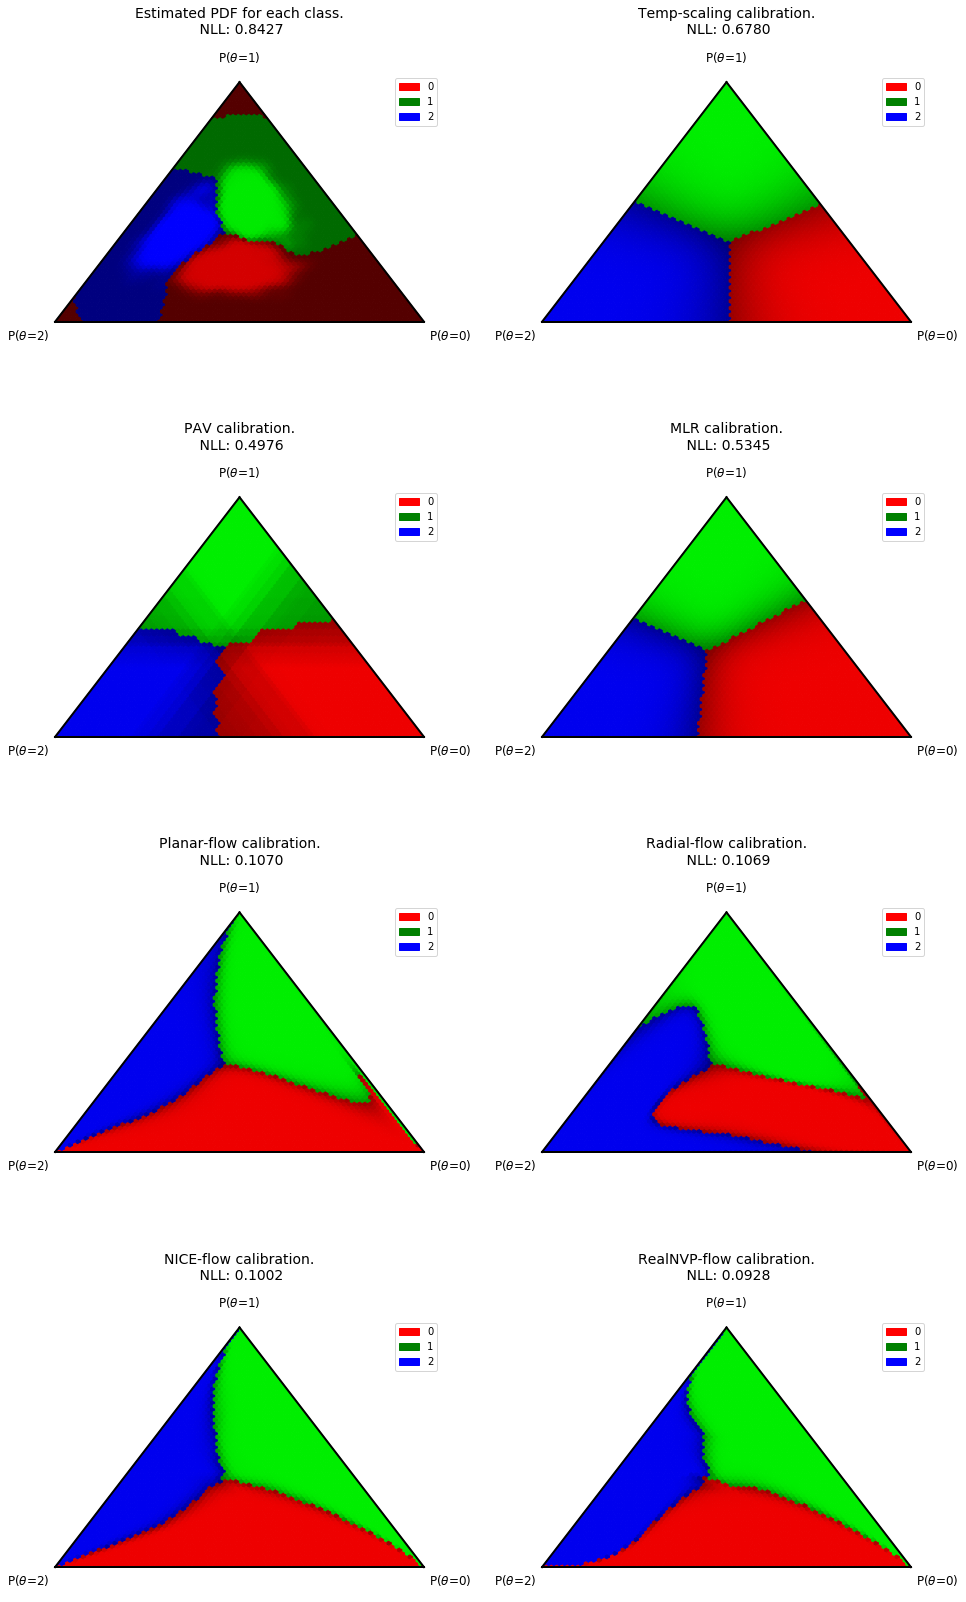

In [9]:
fig, ax_arr = plt.subplots(4, 2, figsize=(16, 28), gridspec_kw={'hspace': 0.5})

ax_arr[0, 0] = plot_pdf_simplex(snt_probs, target=target, ax=ax_arr[0, 0], scale=70,
                                title='Estimated PDF for each class.\n NLL: {:.4f}'.format(nll), fontsize=12);
ax_arr[0, 1] = plot_cal_regions_ternary(temp_cal, ax=ax_arr[0, 1], scale=70,
                             title='Temp-scaling calibration.\n NLL: {:.4f}'.format(nll_temp), fontsize=12);
ax_arr[1, 0] = plot_cal_regions_ternary(pav_cal, ax=ax_arr[1, 0], scale=70,
                             title='PAV calibration.\n NLL: {:.4f}'.format(nll_pav), fontsize=12);
ax_arr[1, 1] = plot_cal_regions_ternary(mlr_cal, ax=ax_arr[1, 1], scale=70,
                             title='MLR calibration.\n NLL: {:.4f}'.format(nll_mlr), fontsize=12);
ax_arr[2, 0] = plot_cal_regions_ternary(pln_cal, ax=ax_arr[2, 0], scale=70,
                             title='Planar-flow calibration.\n NLL: {:.4f}'.format(nll_pln), fontsize=12);
ax_arr[2, 1] = plot_cal_regions_ternary(rdl_cal, ax=ax_arr[2, 1], scale=70,
                             title='Radial-flow calibration.\n NLL: {:.4f}'.format(nll_rdl), fontsize=12);
ax_arr[3, 0] = plot_cal_regions_ternary(nice_cal, ax=ax_arr[3, 0], scale=70,
                             title='NICE-flow calibration.\n NLL: {:.4f}'.format(nll_nice), fontsize=12);
ax_arr[3, 1] = plot_cal_regions_ternary(nvp_cal, ax=ax_arr[3, 1], scale=70,
                             title='RealNVP-flow calibration.\n NLL: {:.4f}'.format(nll_nvp), fontsize=12);

plt.show()

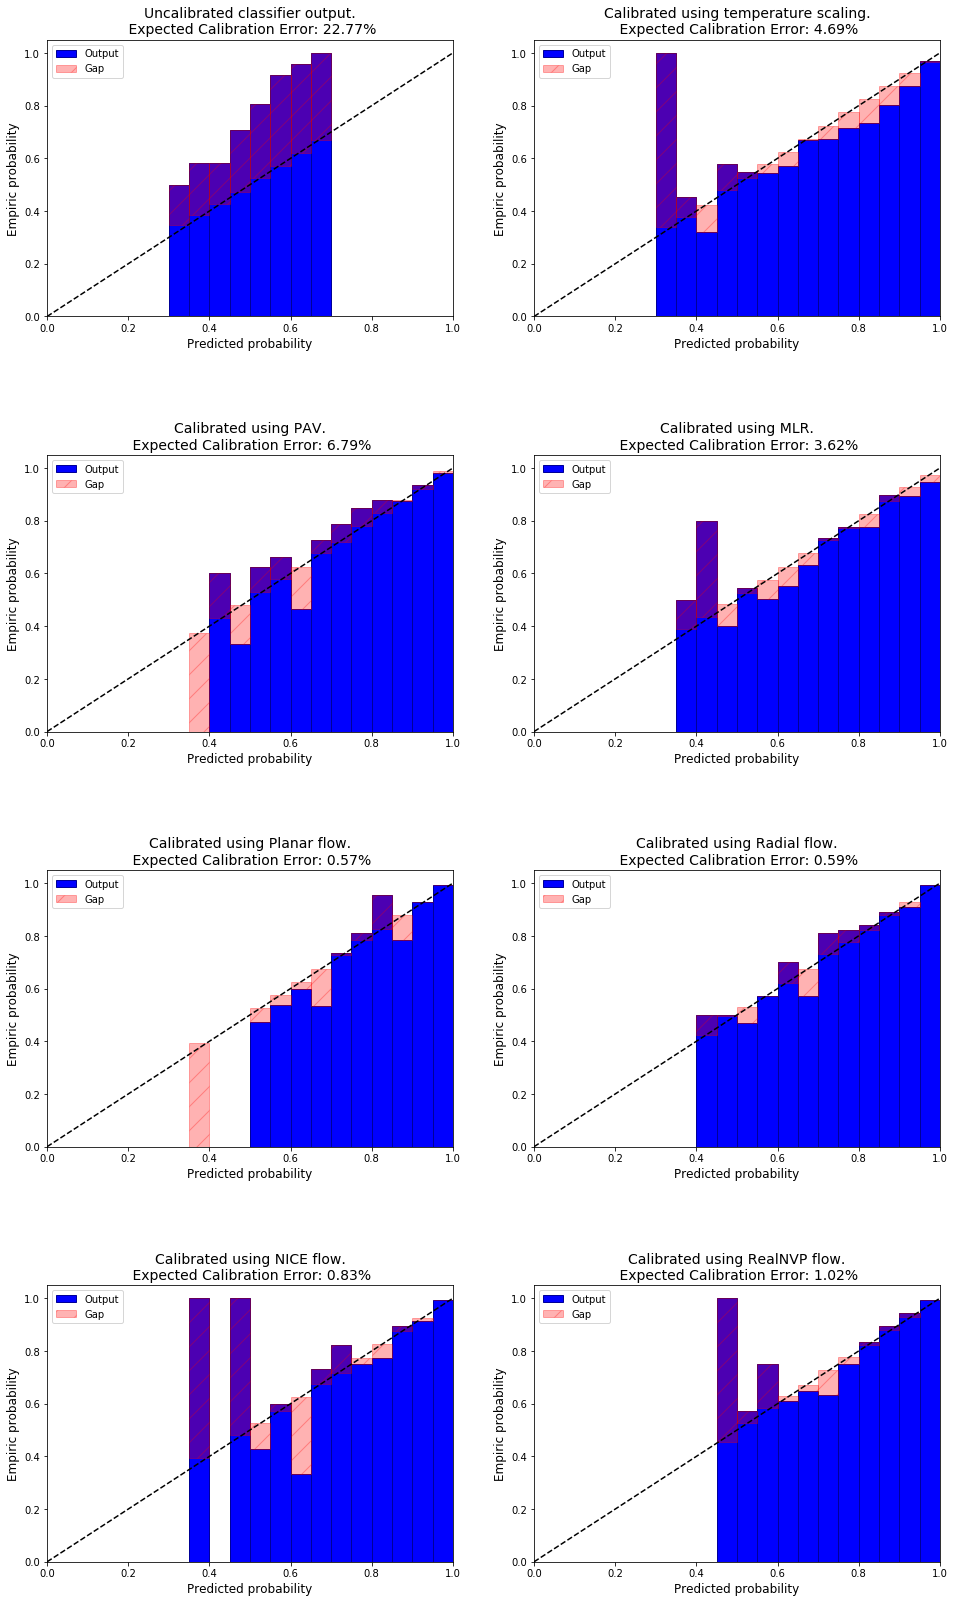

In [10]:
fig, ax_arr = plt.subplots(4, 2, figsize=(16, 28), gridspec_kw={'hspace': 0.5})
ax_arr[0, 0] = reliability_diagram(snt_probs, target, ax=ax_arr[0, 0],
                             title='Uncalibrated classifier output.\n Expected Calibration Error: {:.2%}'.format(ECE), fontsize=12);
ax_arr[0, 1] = reliability_diagram(temp_probs, target, ax=ax_arr[0, 1],
                             title='Calibrated using temperature scaling.\n Expected Calibration Error: {:.2%}'.format(ECE_temp), fontsize=12);
ax_arr[1, 0] = reliability_diagram(pav_probs, target, ax=ax_arr[1, 0],
                             title='Calibrated using PAV.\n Expected Calibration Error: {:.2%}'.format(ECE_pav), fontsize=12);
ax_arr[1, 1] = reliability_diagram(mlr_probs, target, ax=ax_arr[1, 1],
                             title='Calibrated using MLR.\n Expected Calibration Error: {:.2%}'.format(ECE_mlr), fontsize=12);
ax_arr[2, 0] = reliability_diagram(pln_probs, target, ax=ax_arr[2, 0],
                             title='Calibrated using Planar flow.\n Expected Calibration Error: {:.2%}'.format(ECE_pln), fontsize=12);
ax_arr[2, 1] = reliability_diagram(rdl_probs, target, ax=ax_arr[2, 1],
                             title='Calibrated using Radial flow.\n Expected Calibration Error: {:.2%}'.format(ECE_rdl), fontsize=12);
ax_arr[3, 0] = reliability_diagram(nice_probs, target, ax=ax_arr[3, 0],
                             title='Calibrated using NICE flow.\n Expected Calibration Error: {:.2%}'.format(ECE_nice), fontsize=12);
ax_arr[3, 1] = reliability_diagram(nvp_probs, target, ax=ax_arr[3, 1],
                             title='Calibrated using RealNVP flow.\n Expected Calibration Error: {:.2%}'.format(ECE_nvp), fontsize=12);

plt.show()

## Visualize 2-simplex after each Planar layer:

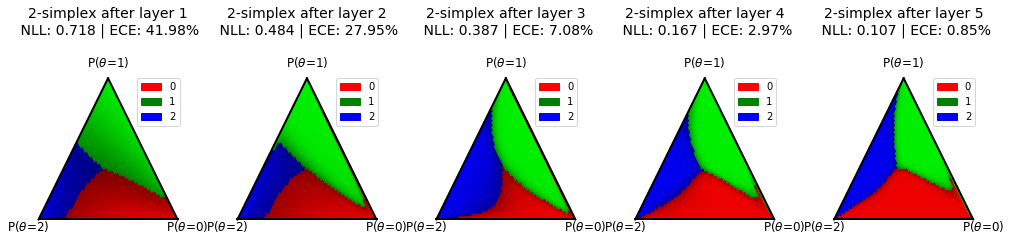

In [11]:
x = torch.as_tensor(snt_logits, dtype=torch.float)
    
fig, ax_arr = plt.subplots(1, 5, figsize=(17, 3), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
layers = []
for i, layer in enumerate(pln_cal.flow.layers):
    layers.append(layer)
    def model(x):
        x = torch.as_tensor(x, dtype=torch.float)
        for _layer in layers:
            x = _layer(x)
        return softmax(x.cpu().detach().numpy(), axis=1)
    x = layer(x)
    probs = softmax(x.cpu().detach().numpy(), axis=1)
    nll = neg_log_likelihood(probs, target)
    ECE = expected_calibration_error(probs, target)
    ax_arr[i] = plot_cal_regions_ternary(model, ax=ax_arr[i], scale=60,
                                         title='2-simplex after layer {}\n NLL: {:.3f} | ECE: {:.2%}'.format(i+1, nll, ECE),
                                         fontsize=12);
    
plt.show()

## Visualize 2-simplex after each Radial layer:

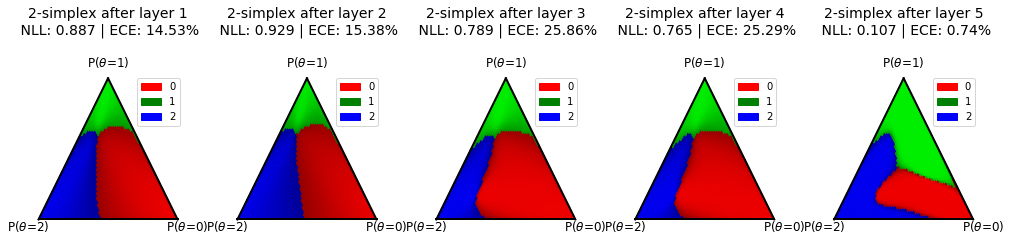

In [12]:
x = torch.as_tensor(snt_logits, dtype=torch.float)
    
fig, ax_arr = plt.subplots(1, 5, figsize=(17, 3), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
layers = []
for i, layer in enumerate(rdl_cal.flow.layers):
    layers.append(layer)
    def model(x):
        x = torch.as_tensor(x, dtype=torch.float)
        for _layer in layers:
            x = _layer(x)
        return softmax(x.cpu().detach().numpy(), axis=1)
    x = layer(x)
    probs = softmax(x.cpu().detach().numpy(), axis=1)
    nll = neg_log_likelihood(probs, target)
    ECE = expected_calibration_error(probs, target)
    ax_arr[i] = plot_cal_regions_ternary(model, ax=ax_arr[i], scale=60,
                                         title='2-simplex after layer {}\n NLL: {:.3f} | ECE: {:.2%}'.format(i+1, nll, ECE),
                                         fontsize=12);
    
plt.show()